<a href="https://colab.research.google.com/github/spoupry/Hello-world/blob/main/Algo_complet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from pathlib import Path
import os.path
import numpy as np 
import matplotlib.pyplot as plt

import statistics

from google.colab import drive
drive.mount('/content/drive')
dir_path = '/content/drive/My Drive/Colab Notebooks/'
#pour les dates
from datetime import datetime, timedelta
from dateutil.parser import parse

Mounted at /content/drive


In [4]:
#chargement du fichier de données
df = pd.read_csv(dir_path + "pm10_daily.csv", delimiter="\t")
#All data in the dataset is in string format. Here we convert them into useful datatypes
df["DateTime"] = pd.to_datetime(df["DateTime"])
#df["Arg12b1f"] = pd.to_numeric(df["Arg12b1f"])
#df["ENI0122B1V1"] = pd.to_numeric(df["ENI0122B1V1"])
#df["ENI0122B2V1"] = pd.to_numeric(df["ENI0122B2V1"])
#print(df.dtypes) # affiche les types du df
#print(df.columns) # acces au colonnes
#print(df.columns[0]) # accès a la première colonne
df.head(2)

,DateTime,Arg12b1f,ENI0122B1V1,ENI0122B2V1
0,2022-03-02 08:22:00,NaN,35.7,42.8
1,2022-03-02 08:22:00,36.2,NaN,NaN


In [5]:
# initialisation du dataset
#Setting the timestamp as index of the dataframe. 
df.set_index('DateTime', inplace=True) #DateTime is now the index. 
#add columns
df["X1"] = '' 
df["X2"] = '' 
df["X3"] = '' 
df.head(2)

,Arg12b1f,ENI0122B1V1,ENI0122B2V1,X1,X2,X3
DateTime,,,,,,
2022-03-02 08:22:00,NaN,35.7,42.8,,,
2022-03-02 08:22:00,36.2,NaN,NaN,,,


In [6]:
#Initialisation variables
StartTime_df = df.index[0]  # starting timestamp dataset
EndTime_df = df.index[-1]   # End timestamp dataset
tau = timedelta(minutes=30) # definiton step
StepTime = StartTime_df + tau  #slice of time
Threshold = 15 # pour 15% d'erreur toléré
Th = 15                         # bonds for outliers
X1raw = pd.Series( [0] , index = [StartTime_df])
X2raw = pd.Series( [0] , index = [StartTime_df])
X3raw = pd.Series( [0] , index = [StartTime_df])
print("Start df",StartTime_df,"End df",EndTime_df,"step",StepTime)
# initialisation global series (4)
# median for row datas
Median = pd.Series([0], index = [StartTime_df])
# output after median voter
Outagg = pd.Series([0], index = [StartTime_df])
# Alert from no data detection
Alert = pd.Series( ['Begin'] , index = [StartTime_df])
# Outliers series corresponding SmS
X1out = pd.Series( [0] , index = [StartTime_df])
X2out = pd.Series( [0] , index = [StartTime_df])
X3out = pd.Series( [0] , index = [StartTime_df])
# Reliable series extracted from median 
X1r = pd.Series( [0] , index = [StartTime_df])
X2r = pd.Series( [0] , index = [StartTime_df])
X3r = pd.Series( [0] , index = [StartTime_df])

Start df 2022-03-02 08:22:00 End df 2022-03-02 20:18:00 step 2022-03-02 08:52:00


# functions

In [24]:
def calculate_median(l):
    l = sorted(l)
    l_len = len(l)
    if l_len < 1:
        return None
    if l_len % 2 == 0 :
        return ( l[(l_len)//2] + l[(l_len//2)-1] ) / 2.0
    else:
        return l[(l_len-1)//2]

#l = [1,2,3,4,5,6]
#print(calculate_median(l)) 

3.5


In [7]:
def affiche(X1,X2,X3):
  print("Start show plot")
  print("lens of series =",len(X1),len(X2),len(X3))
  # affichage series
  plt.figure(figsize=(12,8))
  X1.plot(label='SmS1')
  X2.plot(label='SmS2')
  X3.plot(label='SmS3')
  plt.legend()
  plt.show()


In [8]:
def detect_no_data(X1,X2,X3):
    #detection no Data
    print("Start detection hardware fault")
    HardwareFault=[]
    print("size of series X1,X2,X3 =",len(X1),len(X2),len(X3))
    if (len(X1) == 0): 
      #print("Hardware fault SmS1")
      HardwareFault.append("Hardware Fault SmS1")
    if (len(X2) == 0): 
      #print("Hardware fault SmS2")
      HardwareFault.append("Hardware Fault SmS2")
    if (len(X3) == 0): 
      #print("Hardware fault SmS3")
      HardwareFault.append("Hardware Fault SmS3")
    #if (len(HardwareFault) == 0):
      #HardwareFault.append("no problem")
      
    #print(HardwareFault)
    #Store Hardware fault in Alert
    Alert.loc[StepTime] = HardwareFault
    print("Alert ", HardwareFault ," indice= ", 3 - len(Alert.loc[StepTime]))
    print("End detection hardware fault")

In [13]:
def detect_outliers(X1,X2,X3,Concat):
    print("Start detecting ouliers")
    #evaluate median and calculate MedMax and MedMin for outlier detection
    Median_slice = np.median(np.array(Concat))
    MedMin = Median_slice - (Median_slice*Threshold)//100
    MedMax = Median_slice + (Median_slice*Threshold)//100
    #on stocke la médiane
    Median.loc[StepTime] = Median_slice #input in Median
    #print("Median for raw datas =", Median)
    # boucle de détection ( extraction des valeurs outliers)
    print("Median",Median_slice,"MedMin",MedMin,"MedMax",MedMax)
    X1rl = [] 
    X2rl = []
    X3rl = []
    idx_1rl= []       #stocke les valeurs burtes pour futures détections
    idx_2rl= [] 
    idx_3rl= [] 
    print("Outliers for X1")
    if(len(X1) != 0):
      
      for time, row in X1.iteritems():
        if((row > MedMax) or (row < MedMin)):
          X1out.loc[time] = row 
        else:
          X1r.loc[time] = row
          X1rl.append(row)   #stock in x1r list
          idx_1rl.append(time)
    
    # print(X1)
    # print(X1out)
    # print(X1r)
    print("Outliers for X2")
    if(len(X2) != 0):
      for time, row in X2.iteritems():
          if((row > MedMax) or (row < MedMin)):
            X2out.loc[time] = row 
          else:
            X2r.loc[time] = row
            X2rl.append(row)   #stock in x2r list
            idx_2rl.append(time)
    # print(X2)
    # print(X2out)
    # print(X2r)
    print("Outliers for X3")
    if(len(X3) != 0):
      for time, row in X3.iteritems():
        if((row > MedMax) or (row < MedMin)):
          X3out.loc[time] = row 
        else:
          X3r.loc[time] = row
          X3rl.append(row)   #stock in x3r list
          idx_3rl.append(time)
    # print(X3)
    # print(X3out)
    # print(X3r)
    # construct series
    X1rl = pd.Series(X1rl, index = idx_1rl)
    X2rl = pd.Series(X2rl, index = idx_2rl)
    X3rl = pd.Series(X3rl, index = idx_3rl)
    print("End outlier detection")
    return X1rl,X2rl,X3rl

# Slicer dataframe


Start:  2022-03-02 08:22:00  , End:  2022-03-02 08:52:00
start processing slice
series X1,X2 and X3 created
Start detection hardware fault
size of series X1,X2,X3 = 6 7 7
Alert  []  indice=  3
End detection hardware fault
Start detecting ouliers
Median 16.05 MedMin 14.05 MedMax 18.05
Outliers for X1
Outliers for X2
Outliers for X3
End outlier detection
Start show plot
lens of series = 6 7 7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


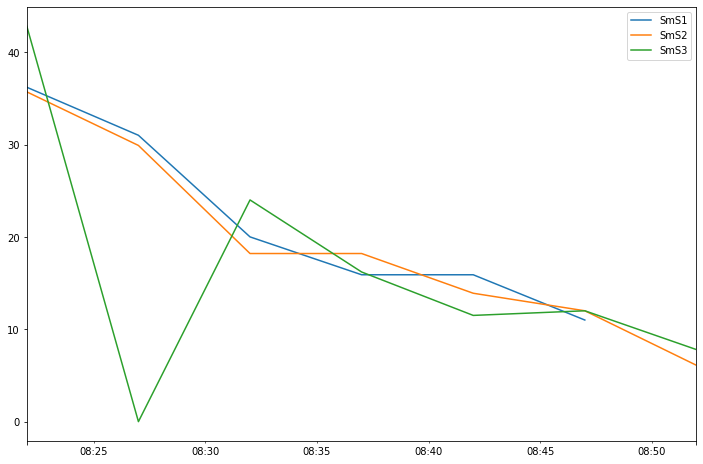

In [19]:
# first slice of time from df
StepTime = StartTime_df + tau
Time_slice_list=[StartTime_df ]
print("Start: ", StartTime_df, " , End: ", StepTime)
def processing(df):
    print("start processing slice")
    #create X1,X2,X3 series   
    X1 = [] 
    X2 = []
    X3 = []
    idx_1= []       #stocke les valeurs burtes pour futures détections
    idx_2= [] 
    idx_3= [] 
    for time, row in df.iterrows():
      if(pd.isna(row[df.columns[0]]) == False ):      #teste si il y a  NaN  
        X1.append(row[df.columns[0]])   #stock in x1 list
        idx_1.append(time)
        X1raw.loc[time] = row[df.columns[0]]     #input in X1raw serie
      if(pd.isna(row[df.columns[1]]) == False ): 
        X2.append(row[df.columns[1]]) 
        idx_2.append(time)
        X2raw.loc[time] = row[df.columns[1]]     #input in X2raw serie            
      if(pd.isna(row[df.columns[2]]) == False ):
        X3.append(row[df.columns[2]])
        idx_3.append(time)
        X3raw.loc[time] = row[df.columns[2]]     #input in X3raw serie
    #Traitements à partir du premier passage
    #print(X1,X2,X3)

    Concat = X1 + X2 + X3
    # create series             
    X1 = pd.Series(X1, index = idx_1)
    X2 = pd.Series(X2, index = idx_2)
    X3 = pd.Series(X3, index = idx_3)
   
    print("series X1,X2 and X3 created")
    # detection hardware fault
    detect_no_data(X1,X2,X3)
    # detection outliers + stocke 
    Xreliable = detect_outliers(X1,X2,X3,Concat)
    # print(Xreliable)
    # affiche(Xreliable[0],Xreliable[1],Xreliable[2]) #voir les petites courbes
    # kernel regression

    return X1,X2,X3,Concat
    

df_slice = df.loc[StartTime_df:StepTime].copy()
l = processing(df_slice)  # X1, X2 X3 et la partie triée
#X1raw=pd.concat([X1raw,l[0]])
#X2raw=pd.concat([X2raw,l[1]])
#X3raw=pd.concat([X3raw,l[2]])
#print(X1raw)
#print(liste[3])
affiche(X1raw,X2raw,X3raw)

In [22]:
# others sclices
for time, row in df.iterrows():
  if(time <= StepTime):
    This_time = time
    #print(time)  
  if(time > StepTime):
    Start_step = time
    StepTime = time + tau
    Time_slice_list.append(Start_step)
    #Time_slice_list.append(StepTime)
    print("Start: ", Start_step, " , End: ", StepTime)
    df_slice = df.loc[Start_step:StepTime].copy()
    processing(df_slice)
    #print(df_slice.head(1))
    #print(df_slice.tail(1))

#Time_slice_list

Start:  2022-03-02 08:53:00  , End:  2022-03-02 09:23:00
                     Arg12b1f  ENI0122B1V1  ENI0122B2V1 X1 X2 X3
DateTime                                                        
2022-03-02 08:53:00       6.1          NaN          NaN         
                     Arg12b1f  ENI0122B1V1  ENI0122B2V1 X1 X2 X3
DateTime                                                        
2022-03-02 09:23:00       NaN          3.6          4.6         
Start:  2022-03-02 09:25:00  , End:  2022-03-02 09:55:00
                     Arg12b1f  ENI0122B1V1  ENI0122B2V1 X1 X2 X3
DateTime                                                        
2022-03-02 09:25:00       3.8          NaN          NaN         
                     Arg12b1f  ENI0122B1V1  ENI0122B2V1 X1 X2 X3
DateTime                                                        
2022-03-02 09:53:00       NaN          6.6          NaN         
Start:  2022-03-02 09:56:00  , End:  2022-03-02 10:26:00
                     Arg12b1f  ENI0122B1V1  ENI01